In [12]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim


import random
from pathlib import Path
import torchvision.transforms.functional as TF

import os
import tarfile
import urllib.request
import deeplake
import kagglehub

from typing import Tuple, List, Dict, Callable

## Data Preparation

Loading STL-10 Dataset

In [2]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
stl10_train = torchvision.datasets.STL10(root='./stl_data', split='train', download=True, transform=transforms)
stl10_test = torchvision.datasets.STL10(root='./stl_data', split='test', download=True, transform=transforms)

In [3]:
train_size = int(0.9 * len(stl10_train))
val_size = len(stl10_train) - train_size
stl10_train_split, stl10_val_split = random_split(stl10_train, [train_size, val_size])

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

In [5]:
BATCH_SIZE = 64

train_loader = DataLoader(stl10_train_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(stl10_val_split, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(stl10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Fine-tuning

Loading ResNet-50

In [6]:
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Fine-tuning ResNet

In [7]:
# REPLACING FINAL LAYER
resnet.fc = torch.nn.Linear(in_features=resnet.fc.in_features, out_features=len(stl10_train.classes), bias=True) 

In [ ]:

# FREEZING BACKBONE
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(DEVICE)
EPOCHS = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.005)

# FULL FINETUNING
# for param in resnet.parameters():
#     param.requires_grad = True
# optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

In [33]:
resnet_train_accuracies = []
resnet_train_losses = []
resnet_val_accuracies = []
resnet_val_losses = []

for epoch in range(EPOCHS):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total
    avg_train_loss = running_loss / len(train_loader)
    resnet_train_accuracies.append(train_acc)
    resnet_train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}")
    print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    resnet.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100. * correct / total
    avg_val_loss = val_running_loss / len(val_loader)
    resnet_val_accuracies.append(val_acc)
    resnet_val_losses.append(avg_val_loss)
    print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")

Epoch 1
	Training Loss: 0.3745, Train Acc: 90.91%
	Validation Loss: 0.1299, Validation Acc: 96.20%
Epoch 2
	Training Loss: 0.0806, Train Acc: 97.71%
	Validation Loss: 0.1119, Validation Acc: 96.40%
Epoch 3
	Training Loss: 0.0446, Train Acc: 99.09%
	Validation Loss: 0.0908, Validation Acc: 97.00%
Epoch 4
	Training Loss: 0.0314, Train Acc: 99.42%
	Validation Loss: 0.1037, Validation Acc: 96.20%
Epoch 5
	Training Loss: 0.0240, Train Acc: 99.56%
	Validation Loss: 0.1042, Validation Acc: 97.00%


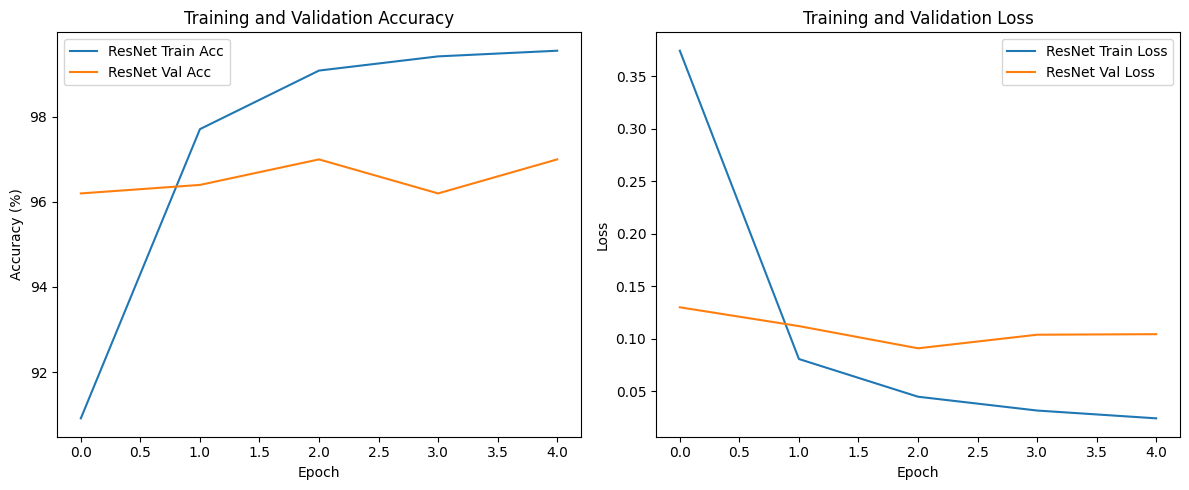

In [42]:
plt.figure(figsize=(12, 5))

# Accuracy curves
plt.subplot(1, 2, 1)
plt.plot(resnet_train_accuracies, label='ResNet Train Acc')
plt.plot(resnet_val_accuracies, label='ResNet Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss curves
plt.subplot(1, 2, 2)
plt.plot(resnet_train_losses, label='ResNet Train Loss')
plt.plot(resnet_val_losses, label='ResNet Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
torch.save(resnet.state_dict(), 'resnet_finetuned.pth')

In [8]:
resnet.load_state_dict(torch.load('resnet_finetuned.pth', map_location=DEVICE))
print("Loaded fine-tuned ResNet-50 weights.")

Loaded fine-tuned ResNet-50 weights.


Loading ViT-S/16

In [9]:
vit = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Fine-tuning ViT

In [10]:
vit.heads.head = torch.nn.Linear(vit.heads.head.in_features, 10)

In [ ]:

# Freeze backbone, only train classification head
for param in vit.parameters():
    param.requires_grad = False
for param in vit.heads.head.parameters():
    param.requires_grad = True
    

vit = vit.to(DEVICE)
EPOCHS = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.heads.head.parameters(), lr=0.005)

# FULL FINETUNING
# for param in vit.parameters():
#     param.requires_grad = True
# optimizer = optim.Adam(vit.parameters(), lr=0.0001)

In [39]:
vit_train_accuracies = []
vit_train_losses = []
vit_val_accuracies = []
vit_val_losses = []

for epoch in range(EPOCHS):
    vit.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total
    avg_train_loss = running_loss / len(train_loader)
    vit_train_accuracies.append(train_acc)
    vit_train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}")
    print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    vit.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = vit(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100. * correct / total
    avg_val_loss = val_running_loss / len(val_loader)
    vit_val_accuracies.append(val_acc)
    vit_val_losses.append(avg_val_loss)
    print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")

Epoch 1
	Training Loss: 0.2017, Train Acc: 95.09%
	Validation Loss: 0.0547, Validation Acc: 98.40%
Epoch 2
	Training Loss: 0.0270, Train Acc: 99.27%
	Validation Loss: 0.0481, Validation Acc: 98.60%
Epoch 3
	Training Loss: 0.0146, Train Acc: 99.67%
	Validation Loss: 0.0433, Validation Acc: 98.80%
Epoch 4
	Training Loss: 0.0067, Train Acc: 99.98%
	Validation Loss: 0.0418, Validation Acc: 99.00%
Epoch 5
	Training Loss: 0.0041, Train Acc: 100.00%
	Validation Loss: 0.0413, Validation Acc: 99.20%


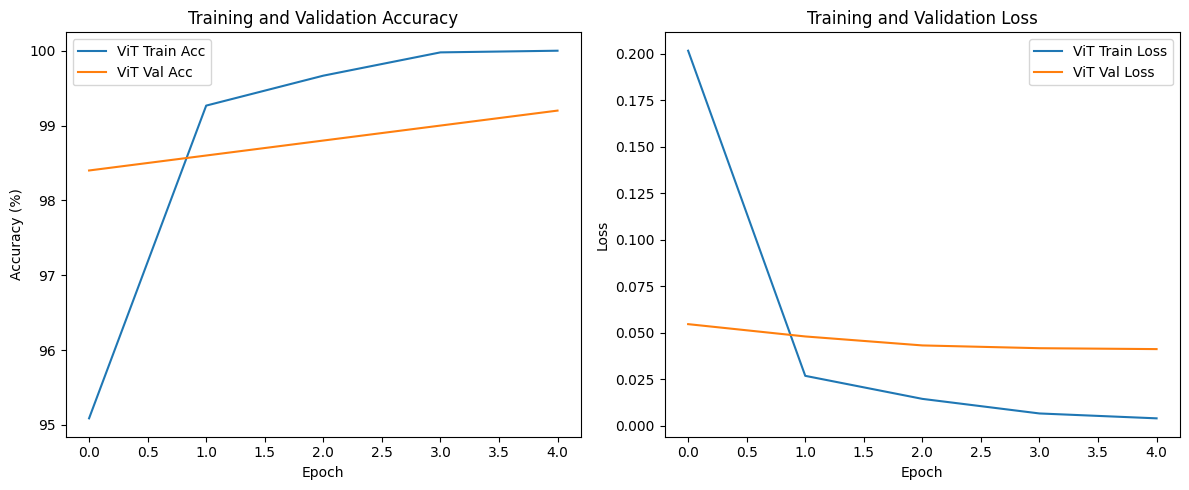

In [43]:
plt.figure(figsize=(12, 5))

# Accuracy curves
plt.subplot(1, 2, 1)
plt.plot(vit_train_accuracies, label='ViT Train Acc')
plt.plot(vit_val_accuracies, label='ViT Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss curves
plt.subplot(1, 2, 2)
plt.plot(vit_train_losses, label='ViT Train Loss')
plt.plot(vit_val_losses, label='ViT Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
torch.save(vit.state_dict(), 'vit_finetuned.pth')

In [11]:
vit.load_state_dict(torch.load('vit_finetuned.pth', map_location=DEVICE))
print("Loaded fine-tuned ViT weights.") 

Loaded fine-tuned ViT weights.


## In-Distribution Performance

Evaluating Fine-Tuned ResNet

In [44]:
resnet.eval()
resnet_test_loss = 0.0
resnet_correct = 0
resnet_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        resnet_test_loss += loss.item()
        _, predicted = outputs.max(1)
        resnet_total += labels.size(0)
        resnet_correct += predicted.eq(labels).sum().item()

resnet_test_acc = 100. * resnet_correct / resnet_total
resnet_avg_test_loss = resnet_test_loss / len(test_loader)
print(f"ResNet-50 Test Loss: {resnet_avg_test_loss:.4f}, Test Acc: {resnet_test_acc:.2f}%")

ResNet-50 Test Loss: 0.1004, Test Acc: 96.72%


Evaluating Fine-Tuned ViT

In [45]:
vit.eval()
vit_test_loss = 0.0
vit_correct = 0
vit_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        loss = criterion(outputs, labels)
        vit_test_loss += loss.item()
        _, predicted = outputs.max(1)
        vit_total += labels.size(0)
        vit_correct += predicted.eq(labels).sum().item()

vit_test_acc = 100. * vit_correct / vit_total
vit_avg_test_loss = vit_test_loss / len(test_loader)
print(f"ViT-S/16 Test Loss: {vit_avg_test_loss:.4f}, Test Acc: {vit_test_acc:.2f}%")

ViT-S/16 Test Loss: 0.0485, Test Acc: 98.51%


## Color-bias Test

Grayscale Dataset

In [46]:
transforms_grayscale = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
stl10_test_grayscale = torchvision.datasets.STL10(root='./stl_data', split='test', download=True, transform=transforms_grayscale)
test_loader = DataLoader(stl10_test_grayscale, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Evaluating Fine-Tuned ResNet

In [47]:
resnet.eval()
resnet_gray_correct = 0
resnet_gray_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        _, predicted = outputs.max(1)
        resnet_gray_total += labels.size(0)
        resnet_gray_correct += predicted.eq(labels).sum().item()

resnet_gray_acc = 100. * resnet_gray_correct / resnet_gray_total
print(f"ResNet-50 Grayscale Test Acc: {resnet_gray_acc:.2f}%")
print(f"ResNet-50 Accuracy Drop: {resnet_test_acc - resnet_gray_acc:.2f}%")

ResNet-50 Grayscale Test Acc: 92.17%
ResNet-50 Accuracy Drop: 4.55%


Evaluating Fine-Tuned ViT

In [48]:
vit.eval()
vit_gray_correct = 0
vit_gray_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        _, predicted = outputs.max(1)
        vit_gray_total += labels.size(0)
        vit_gray_correct += predicted.eq(labels).sum().item()

vit_gray_acc = 100. * vit_gray_correct / vit_gray_total
print(f"ViT-S/16 Grayscale Test Acc: {vit_gray_acc:.2f}%")
print(f"ViT-S/16 Accuracy Drop: {vit_test_acc - vit_gray_acc:.2f}%")

ViT-S/16 Grayscale Test Acc: 96.22%
ViT-S/16 Accuracy Drop: 2.29%


## Shape vs. Texture Bias – Stylized Images

Use this repo: https://github.com/rgeirhos/Stylized-ImageNet

## Translation Invariance Test

Translated Dataset

In [61]:
SHIFT_PIXELS = 30

DIRECTIONS = {
    "up": (0, -SHIFT_PIXELS),
    "down": (0, SHIFT_PIXELS),
    "left": (-SHIFT_PIXELS, 0),
    "right": (SHIFT_PIXELS, 0),
    "up_left": (-SHIFT_PIXELS, -SHIFT_PIXELS),
    "up_right": (SHIFT_PIXELS, -SHIFT_PIXELS),
    "down_left": (-SHIFT_PIXELS, SHIFT_PIXELS),
    "down_right": (SHIFT_PIXELS, SHIFT_PIXELS),
}

def make_shift_transform_affine(dx: int, dy: int, fill=0):
    """
    PIL -> resize -> affine translate -> tensor -> normalize
    """
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(224),
        torchvision.transforms.Lambda(lambda img: torchvision.transforms.functional.affine(
            img,
            angle=0,
            translate=(dx, dy),   # pixels after resize (224x224)
            scale=1.0,
            shear=0.0,
            fill=fill
        )),
            
        torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

class RollShiftTransform:
    """
    PIL -> resize -> tensor -> torch.roll (circular shift) -> normalize
    No padding borders (wrap-around).
    """
    def __init__(self, dx: int, dy: int):
        self.dx, self.dy = dx, dy
        self._resize = torchvision.transforms.Resize((224, 224), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
        self._to_tensor = torchvision.transforms.ToTensor()
        self._norm = torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    def __call__(self, img_pil):
        img_pil = self._resize(img_pil)
        x = self._to_tensor(img_pil)            # [C, H, W]
        x = torch.roll(x, shifts=(self.dy, self.dx), dims=(1, 2))
        x = self._norm(x)
        return x


class RandomShiftSTL10(torchvision.datasets.STL10):
    """
    Each sample is shifted by a random direction from DIRECTIONS.
    mode='affine' -> padding borders (fill)
    mode='roll'   -> circular wrap-around (no borders)
    """
    def __init__(self, root, split, download, directions, fill=0, mode='affine'):
        super().__init__(root=root, split=split, download=download, transform=None)
        assert mode in ('affine', 'roll')
        self.directions = list(directions.items())  # [(name, (dx,dy)), ...]
        self.fill = fill
        self.mode = mode

    def __getitem__(self, index):
        img, target = super().__getitem__(index)   # img is PIL
        name, (dx, dy) = random.choice(self.directions)

        if self.mode == 'affine':
            x = make_shift_transform_affine(dx, dy, fill=self.fill)(img)
        else:
            x = RollShiftTransform(dx, dy)(img)

        return x, target, name

def get_mixed_shift_loader(split="test", batch_size=BATCH_SIZE, fill=0, seed=None, mode='affine'):
    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)
    ds = RandomShiftSTL10(root="./stl_data", split=split, download=True,
                          directions=DIRECTIONS, fill=fill, mode=mode)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2)


# shifted_loader = get_mixed_shift_loader(split="test", seed=1337, mode='affine', fill=0)
shifted_loader  = get_mixed_shift_loader(split="test", seed=1337, mode='roll')

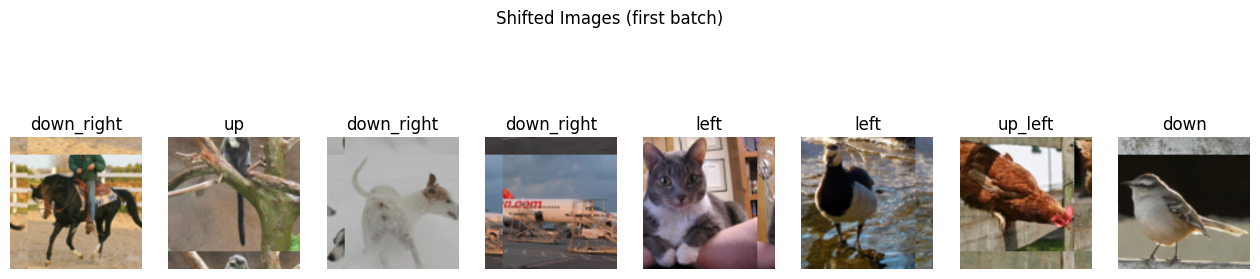

In [62]:
# Visualize a batch of images from shifted_loader
import matplotlib.pyplot as plt

# Get a batch from shifted_loader
images, labels, directions = next(iter(shifted_loader))

# Move images to CPU and denormalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

images_vis = images[:8].cpu() * std + mean  # Take first 8 images

plt.figure(figsize=(16, 4))
for i in range(8):
    img = images_vis[i].permute(1, 2, 0).numpy()
    img = img.clip(0, 1)
    plt.subplot(1, 8, i + 1)
    plt.imshow(img)
    plt.title(directions[i])
    plt.axis('off')
plt.suptitle("Shifted Images (first batch)")
plt.show()

Evaluating ResNet

In [63]:
resnet.eval()
resnet_shift_correct = 0
resnet_shift_total = 0

with torch.no_grad():
    for images, labels, direction in shifted_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        _, predicted = outputs.max(1)
        resnet_shift_total += labels.size(0)
        resnet_shift_correct += predicted.eq(labels).sum().item()

resnet_shift_acc = 100. * resnet_shift_correct / resnet_shift_total
print(f"ResNet-50 Shifted Test Acc: {resnet_shift_acc:.2f}%")

ResNet-50 Shifted Test Acc: 96.04%


Evaluating ViT

In [64]:
vit.eval()
vit_shift_correct = 0
vit_shift_total = 0

with torch.no_grad():
    for images, labels, direction in shifted_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        _, predicted = outputs.max(1)
        vit_shift_total += labels.size(0)
        vit_shift_correct += predicted.eq(labels).sum().item()

vit_shift_acc = 100. * vit_shift_correct / vit_shift_total
print(f"ViT-S/16 Shifted Test Acc: {vit_shift_acc:.2f}%")

ViT-S/16 Shifted Test Acc: 97.85%


## Permutation Test

In [13]:
def _check_divisible(H: int, W: int, patch_size: int):
    assert H % patch_size == 0 and W % patch_size == 0, \
        f"Image size {H}x{W} must be divisible by patch_size={patch_size}."

def _grid_shape(H: int, W: int, patch_size: int) -> Tuple[int, int]:
    _check_divisible(H, W, patch_size)
    return H // patch_size, W // patch_size

def _tensor_to_patches(x: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    x: [C,H,W] (already 224x224)
    returns patches: [C, nH, nW, p, p]
    """
    C, H, W = x.shape
    nH, nW = _grid_shape(H, W, patch_size)
    # use unfold for robust slicing
    patches = x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    # patches shape: [C, nH, nW, p, p]
    return patches

def _patches_to_tensor(patches: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    patches: [C, nH, nW, p, p] -> x: [C, H, W]
    """
    C, nH, nW, p, _ = patches.shape
    H, W = nH * p, nW * p
    out = torch.empty((C, H, W), dtype=patches.dtype, device=patches.device)
    for i in range(nH):
        for j in range(nW):
            out[:, i*p:(i+1)*p, j*p:(j+1)*p] = patches[:, i, j]
    return out

class PatchShuffleSTL10(torchvision.datasets.STL10):
    """
    Disrupt global structure by shuffling patch positions on a fixed grid.
    Each sample uses a fresh random permutation (set seed for reproducibility).
    """
    def __init__(self, root="./stl_data", split="test", download=True,
                 patch_size: int = 32):
        super().__init__(root=root, split=split, download=download, transform=None)
        self.patch_size = patch_size
        self.base_tfm = torchvision.transforms.Compose([
            torchvision.transforms.Resize(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])

    def __getitem__(self, index):
        img, target = super().__getitem__(index)       # PIL
        x = self.base_tfm(img)                         # [C,224,224]
        patches = _tensor_to_patches(x, self.patch_size)  # [C,nH,nW,p,p]
        C, nH, nW, p, _ = patches.shape

        # Flatten grid indices, permute, then place back row-major
        idxs = list(range(nH * nW))
        random.shuffle(idxs)
        shuffled = torch.empty_like(patches)
        for new_flat, old_flat in enumerate(idxs):
            ni, nj = divmod(new_flat, nW)
            oi, oj = divmod(old_flat, nW)
            shuffled[:, ni, nj] = patches[:, oi, oj]

        out = _patches_to_tensor(shuffled, self.patch_size)  # [C,224,224]
        return out, target


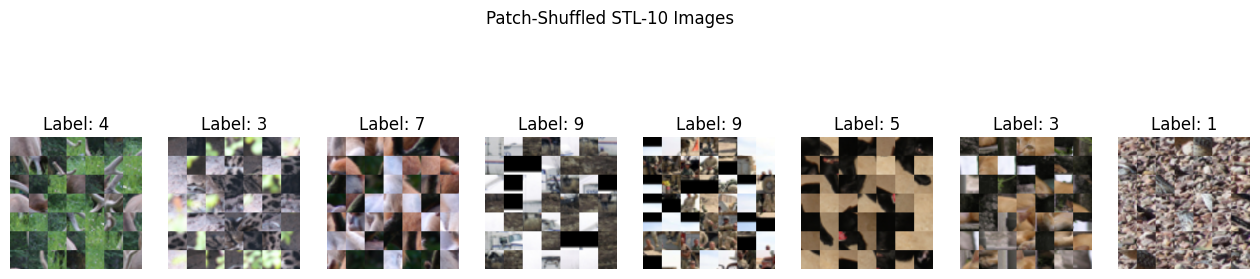

In [16]:
patch_shuffle_dataset = PatchShuffleSTL10(root="./stl_data", split="test", download=True, patch_size=32)
patch_shuffle_loader = DataLoader(patch_shuffle_dataset, batch_size=8, shuffle=True, num_workers=2)

images, labels = next(iter(patch_shuffle_loader))

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images_vis = images * std + mean

plt.figure(figsize=(16, 4))
for i in range(images_vis.size(0)):
    img = images_vis[i].permute(1, 2, 0).numpy().clip(0, 1)
    plt.subplot(1, images_vis.size(0), i + 1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Patch-Shuffled STL-10 Images")
plt.show()

Evaluating ResNet

In [20]:
resnet.to(DEVICE)
resnet.eval()
resnet_patch_shuffled_correct = 0
resnet_patch_shuffled_total = 0

with torch.no_grad():
    for images, labels in patch_shuffle_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        _, predicted = outputs.max(1)
        resnet_patch_shuffled_total += labels.size(0)
        resnet_patch_shuffled_correct += predicted.eq(labels).sum().item()

resnet_patch_shuffled_acc = 100. * resnet_patch_shuffled_correct / resnet_patch_shuffled_total
print(f"ResNet-50 Patch Shuffled Test Acc: {resnet_patch_shuffled_acc:.2f}%")

ResNet-50 Patch Shuffled Test Acc: 74.15%


Evaluating ViT

In [22]:
vit.to(DEVICE)
vit.eval()
vit_patch_shuffled__correct = 0
vit_patch_shuffled__total = 0

with torch.no_grad():
    for images, labels in patch_shuffle_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        _, predicted = outputs.max(1)
        vit_patch_shuffled__total += labels.size(0)
        vit_patch_shuffled__correct += predicted.eq(labels).sum().item()

vit_patch_shuffled__acc = 100. * vit_patch_shuffled__correct / vit_patch_shuffled__total
print(f"ViT-S/16 Patch Shuffled Test Acc: {vit_patch_shuffled__acc:.2f}%")

ViT-S/16 Patch Shuffled Test Acc: 83.95%


## Occlusion Test

In [30]:
class PatchOcclusionRandomSTL10(torchvision.datasets.STL10):
    def __init__(self, root="./stl_data", split="test", download=True,
                 patch_size: int = 32, num_patches_to_mask: int = 12,
                 fill_mode: str = "black"):
        super().__init__(root=root, split=split, download=download, transform=None)
        self.patch_size = patch_size
        self.num_mask = num_patches_to_mask
        self.fill_mode = fill_mode
        self._resize_to_tensor = torchvision.transforms.Compose([
            torchvision.transforms.Resize(224),
            torchvision.transforms.ToTensor()
        ])
        self._norm = torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    def __getitem__(self, index):
        img, target = super().__getitem__(index)  # PIL

        if self.fill_mode == "black":
            # fill with visible black ([0,0,0]) in pixel space, then normalize
            x = self._resize_to_tensor(img)       # [C,224,224] in [0,1]
            patches = _tensor_to_patches(x, self.patch_size)
            C, nH, nW, p, _ = patches.shape
            K = min(self.num_mask, nH * nW)
            coords = random.sample(range(nH * nW), K)
            black_tensor = torch.zeros((C, p, p), dtype=x.dtype, device=x.device)
            for flat in coords:
                i, j = divmod(flat, nW)
                patches[:, i, j] = black_tensor
            out = _patches_to_tensor(patches, self.patch_size)
            out = self._norm(out)

        elif self.fill_mode == "zeros":
            # normalize first, then zero patches
            x = self._resize_to_tensor(img)
            x = self._norm(x)
            patches = _tensor_to_patches(x, self.patch_size)
            C, nH, nW, p, _ = patches.shape
            K = min(self.num_mask, nH * nW)
            coords = random.sample(range(nH * nW), K)
            for flat in coords:
                i, j = divmod(flat, nW)
                patches[:, i, j] = 0.0
            out = _patches_to_tensor(patches, self.patch_size)

        elif self.fill_mode == "mean":
            # fill with ImageNet mean in pixel space, then normalize
            x = self._resize_to_tensor(img)
            patches = _tensor_to_patches(x, self.patch_size)
            C, nH, nW, p, _ = patches.shape
            K = min(self.num_mask, nH * nW)
            coords = random.sample(range(nH * nW), K)
            mean_tensor = torch.tensor([0.485,0.456,0.406], dtype=x.dtype, device=x.device).view(3,1,1)
            for flat in coords:
                i, j = divmod(flat, nW)
                patches[:, i, j] = mean_tensor
            out = _patches_to_tensor(patches, self.patch_size)
            out = self._norm(out)
        else:
            raise ValueError("fill_mode must be 'black', 'zeros' or 'mean'")

        return out, target

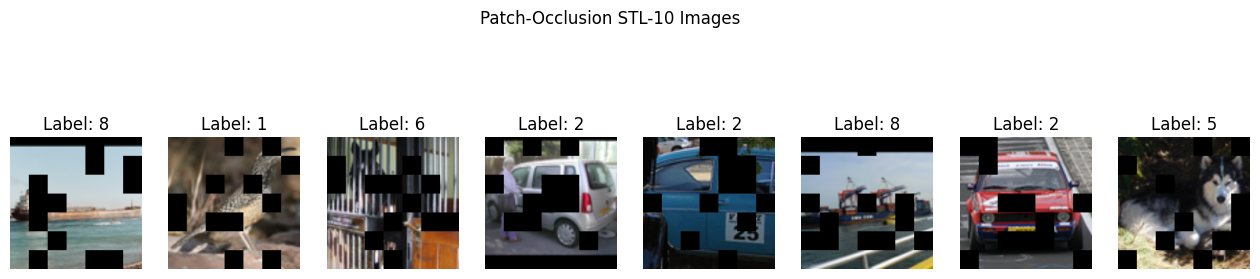

In [31]:
patch_occlusion_dataset = PatchOcclusionRandomSTL10(root="./stl_data", split="test", download=True, patch_size=32)
patch_occlusion_loader = DataLoader(patch_occlusion_dataset, batch_size=8, shuffle=True, num_workers=2)

images, labels = next(iter(patch_occlusion_loader))

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images_vis = images * std + mean

plt.figure(figsize=(16, 4))
for i in range(images_vis.size(0)):
    img = images_vis[i].permute(1, 2, 0).numpy().clip(0, 1)
    plt.subplot(1, images_vis.size(0), i + 1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Patch-Occlusion STL-10 Images")
plt.show()

Evaluating ResNet

In [32]:
resnet.to(DEVICE)
resnet.eval()
resnet_patch_occlusion_correct = 0
resnet_patch_occlusion_total = 0

with torch.no_grad():
    for images, labels in patch_occlusion_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        _, predicted = outputs.max(1)
        resnet_patch_occlusion_total += labels.size(0)
        resnet_patch_occlusion_correct += predicted.eq(labels).sum().item()

resnet_patch_occlusion_acc = 100. * resnet_patch_occlusion_correct / resnet_patch_occlusion_total
print(f"ResNet-50 Patch Occlusion Test Acc: {resnet_patch_occlusion_acc:.2f}%")

ResNet-50 Patch Occlusion Test Acc: 90.92%


Evaluating ViT

In [33]:
vit.to(DEVICE)
vit.eval()
vit_patch_occlusion__correct = 0
vit_patch_occlusion__total = 0

with torch.no_grad():
    for images, labels in patch_shuffle_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        _, predicted = outputs.max(1)
        vit_patch_occlusion__total += labels.size(0)
        vit_patch_occlusion__correct += predicted.eq(labels).sum().item()

vit_patch_occlusion__acc = 100. * vit_patch_occlusion__correct / vit_patch_occlusion__total
print(f"ViT-S/16 Patch Occlusion Test Acc: {vit_patch_occlusion__acc:.2f}%")

ViT-S/16 Patch Occlusion Test Acc: 84.05%


In [23]:
# # ----------------------------
# # 3) Patch Occlusion – Center
# # ----------------------------
# class PatchOcclusionCenterSTL10(torchvision.datasets.STL10):
#     """
#     Mask a single centered square region of given pixel size (on the 224x224 image).
#     """
#     def __init__(self, root="./stl_data", split="test", download=True,
#                  center_size: int = 64, fill_mode: str = "zeros"):
#         """
#         center_size: side length of square (pixels in 224x224 space).
#         fill_mode: "zeros" (post-normalization zeros) or "mean" (pre-normalization mean).
#         """
#         super().__init__(root=root, split=split, download=download, transform=None)
#         self.center_size = center_size
#         self.fill_mode = fill_mode
#         self._resize_to_tensor = T.Compose([T.Resize((224, 224)), T.ToTensor()])
#         self._norm = T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD])

#     def __getitem__(self, index):
#         img, target = super().__getitem__(index)  # PIL
#         if self.fill_mode == "zeros":
#             x = self._resize_to_tensor(img)
#             x = self._norm(x)
#             C, H, W = x.shape
#             cs = min(self.center_size, min(H, W))
#             y0 = (H - cs) // 2
#             x0 = (W - cs) // 2
#             x[:, y0:y0+cs, x0:x0+cs] = 0.0
#             return x, target
#         elif self.fill_mode == "mean":
#             x = self._resize_to_tensor(img)   # [0,1]
#             C, H, W = x.shape
#             cs = min(self.center_size, min(H, W))
#             y0 = (H - cs) // 2
#             x0 = (W - cs) // 2
#             mean_tensor = torch.tensor(IMAGENET_MEAN, dtype=x.dtype, device=x.device).view(3,1,1)
#             x[:, y0:y0+cs, x0:x0+cs] = mean_tensor
#             x = self._norm(x)
#             return x, target
#         else:
#             raise ValueError("fill_mode must be 'zeros' or 'mean'")

## Feature Representation Analysis

In [ ]:
import os
import csv
import argparse
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.io import read_image

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm


# ----------------------------
# Config
# ----------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# STL-10 class names (0..9) for nicer legends (optional)
STL10_CLASSES = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]

# ----------------------------
# Transforms for ResNet/Vit (ImageNet)
# ----------------------------
def make_eval_transform(img_size=224):
    return T.Compose([
        # Ensure 3-channel (handles grayscale inputs safely)
        T.Lambda(lambda im: im.convert("RGB") if hasattr(im, "mode") else im),
        T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BILINEAR),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

# ----------------------------
# Flexible dataset loader
#   - If folder has subfolders per class: use ImageFolder
#   - Else if folder has labels.txt (filename \t label_int): use FlatFolderWithLabels
# ----------------------------
class FlatFolderWithLabels(Dataset):
    """
    Expects:
      root/
        labels.txt        (lines: "<filename>\\t<label_int>")
        *.png/*.jpg...
    """
    def __init__(self, root, transform=None):
        self.root = Path(root)
        self.transform = transform
        labels_path = self.root / "labels.txt"
        if not labels_path.exists():
            raise FileNotFoundError(f"{labels_path} not found. Provide ImageFolder structure or labels.txt.")

        self.samples = []
        with open(labels_path, "r", newline="") as f:
            reader = csv.reader(f, delimiter="\t")
            for row in reader:
                if len(row) < 2:
                    continue
                fname, label = row[0].strip(), int(row[1].strip())
                self.samples.append((self.root / fname, label))

        if len(self.samples) == 0:
            raise RuntimeError(f"No samples read from {labels_path}.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = torchvision.io.read_image(str(p))  # tensor [C,H,W], possibly 1/3 channels
        # convert to PIL for consistent transforms
        img = T.ToPILImage()(img)
        if self.transform:
            img = self.transform(img)
        return img, y

def make_loader_for_folder(folder, batch_size=128, num_workers=2, img_size=224):
    folder = Path(folder)
    tfm = make_eval_transform(img_size)

    # Heuristic: if labels.txt exists => flat; else try ImageFolder
    if (folder / "labels.txt").exists():
        ds = FlatFolderWithLabels(folder, transform=tfm)
        class_names = STL10_CLASSES  # assumes labels consistent with STL-10
    else:
        ds = torchvision.datasets.ImageFolder(folder, transform=tfm)
        # try to map to STL-10 names if exactly 10 classes and sorted index matches
        class_names = ds.classes if hasattr(ds, "classes") else [str(i) for i in range(len(set([y for _, y in ds])))]
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return loader, class_names

# ----------------------------
# Models + penultimate extraction
# ----------------------------
def load_resnet50():
    weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet50(weights=weights)
    model.to(DEVICE).eval()
    # penultimate = before final fc (i.e., 2048-d after avgpool)
    feature_extractor = nn.Sequential(*(list(model.children())[:-1])).to(DEVICE).eval()  # -> [N,2048,1,1]
    return model, feature_extractor, 2048

def load_vit_b16():
    weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
    vit = torchvision.models.vit_b_16(weights=weights).to(DEVICE).eval()
    # vit.forward_features(x) -> [N, hidden_dim]
    hidden_dim = vit.heads.head.in_features  # typically 768
    return vit, hidden_dim

@torch.no_grad()
def extract_resnet_penultimate(feature_extractor, loader, domain_name):
    feats, labels, domains = [], [], []
    for x, y in tqdm(loader, desc=f"ResNet feats [{domain_name}]", leave=False):
        x = x.to(DEVICE, non_blocking=True)
        f = feature_extractor(x)         # [N,2048,1,1]
        f = torch.flatten(f, 1)          # [N,2048]
        feats.append(f.cpu())
        labels.append(y)
        domains += [domain_name] * x.size(0)
    return torch.cat(feats, 0).numpy(), torch.cat(labels, 0).numpy(), np.array(domains)

@torch.no_grad()
def extract_vit_penultimate(vit, loader, domain_name):
    feats, labels, domains = [], [], []
    for x, y in tqdm(loader, desc=f"ViT feats [{domain_name}]", leave=False):
        x = x.to(DEVICE, non_blocking=True)
        f = vit.forward_features(x)      # [N, hidden_dim], penultimate before head
        feats.append(f.cpu())
        labels.append(y)
        domains += [domain_name] * x.size(0)
    return torch.cat(feats, 0).numpy(), torch.cat(labels, 0).numpy(), np.array(domains)

# ----------------------------
# Dimensionality reduction + plotting
# ----------------------------
def reduce_embeddings(X, method="tsne", pca_dim=50, tsne_perplexity=30, tsne_seed=42):
    if method.lower() == "pca":
        reducer = PCA(n_components=2, random_state=tsne_seed)
        Z = reducer.fit_transform(X)
        info = "PCA"
    else:
        # (optional) PCA preprocessing improves t-SNE speed/stability
        Xp = PCA(n_components=min(pca_dim, X.shape[1])).fit_transform(X)
        reducer = TSNE(n_components=2, perplexity=tsne_perplexity, learning_rate="auto",
                       init="pca", random_state=tsne_seed, n_iter=1000, verbose=0)
        Z = reducer.fit_transform(Xp)
        info = f"t-SNE (perp={tsne_perplexity})"
    return Z, info

def plot_scatter(Z, labels, domains, class_names, title, out_path=None, max_points_per_class=1000):
    """
    Z: [N,2], labels: [N], domains: [N] (strings)
    Different colors for classes, different markers for domains.
    """
    plt.figure(figsize=(9, 7))
    labels = np.asarray(labels)
    domains = np.asarray(domains)

    # handle markers per domain
    unique_domains = sorted(list(set(domains.tolist())))
    markers = ["o", "s", "^", "D", "v", "P", "X", "*"]
    marker_map = {d: markers[i % len(markers)] for i, d in enumerate(unique_domains)}

    unique_classes = sorted(list(set(labels.tolist())))
    # limit points per class to keep scatter readable
    idxs_to_plot = []
    for c in unique_classes:
        idxs_c = np.where(labels == c)[0]
        if max_points_per_class and len(idxs_c) > max_points_per_class:
            idxs_c = np.random.choice(idxs_c, size=max_points_per_class, replace=False)
        idxs_to_plot.append(idxs_c)
    idxs_to_plot = np.concatenate(idxs_to_plot) if len(idxs_to_plot) else np.arange(len(labels))

    scatter_handles = {}
    for d in unique_domains:
        scatter_handles[d] = None

    # plot by class & domain
    for c in unique_classes:
        idx_c = idxs_to_plot[labels[idxs_to_plot] == c]
        for d in unique_domains:
            idx_cd = idx_c[domains[idx_c] == d]
            if len(idx_cd) == 0:
                continue
            h = plt.scatter(Z[idx_cd, 0], Z[idx_cd, 1],
                            label=f"{class_names[c]} ({d})",
                            alpha=0.7, s=12, marker=marker_map[d])
            scatter_handles[d] = h  # keep last handle per domain (for marker legend)

    plt.title(title)
    plt.xlabel("dim 1"); plt.ylabel("dim 2")
    # Class legend (colors) – reduce clutter by showing classes only
    # Build a legend with just classes (one entry per class), ignoring domains
    from matplotlib.lines import Line2D
    color_legend_elements = []
    cmap = plt.cm.get_cmap('tab10', len(unique_classes))
    # The scatter above already used default color cycling; to guarantee class-color mapping,
    # you could color by class explicitly; keeping simple here.

    plt.grid(alpha=0.2)
    if out_path:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        print(f"Saved plot to {out_path}")
    plt.show()

# ----------------------------
# Main
# ----------------------------
def main():
    parser = argparse.ArgumentParser(description="Embed STL10 subsets with ResNet50 & ViT-B/16 and plot PCA/t-SNE.")
    parser.add_argument("--datasets", nargs="+", default=["stl10_test", "stl10_test_grayscale"],
                        help="List of dataset folders. Each can be ImageFolder or flat folder with labels.txt")
    parser.add_argument("--names", nargs="+", default=["normal", "grayscale"],
                        help="Domain names corresponding 1:1 with --datasets")
    parser.add_argument("--batch-size", type=int, default=128)
    parser.add_argument("--img-size", type=int, default=224)
    parser.add_argument("--max-per-class", type=int, default=1000, help="Max plotted points per class.")
    parser.add_argument("--method", choices=["pca", "tsne"], default="tsne")
    parser.add_argument("--tsne-perp", type=float, default=30.0)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--outdir", type=str, default="emb_plots")
    args = parser.parse_args()

    assert len(args.datasets) == len(args.names), "Provide same number of --datasets and --names."

    # Load loaders
    loaders = []
    class_names = STL10_CLASSES
    for ds_path, name in zip(args.datasets, args.names):
        loader, class_names = make_loader_for_folder(ds_path, batch_size=args.batch_size,
                                                     num_workers=2, img_size=args.img_size)
        loaders.append((name, loader))

    # Load models
    resnet, resnet_feats, res_dim = load_resnet50()
    vit, vit_dim = load_vit_b16()

    # Extract embeddings per dataset
    X_res_list, y_res_list, d_res_list = [], [], []
    X_vit_list, y_vit_list, d_vit_list = [], [], []

    for domain_name, loader in loaders:
        Xr, yr, dr = extract_resnet_penultimate(resnet_feats, loader, domain_name)
        Xv, yv, dv = extract_vit_penultimate(vit, loader, domain_name)
        X_res_list.append(Xr); y_res_list.append(yr); d_res_list.append(dr)
        X_vit_list.append(Xv); y_vit_list.append(yv); d_vit_list.append(dv)

    X_res = np.concatenate(X_res_list, axis=0)
    y_res = np.concatenate(y_res_list, axis=0)
    d_res = np.concatenate(d_res_list, axis=0)

    X_vit = np.concatenate(X_vit_list, axis=0)
    y_vit = np.concatenate(y_vit_list, axis=0)
    d_vit = np.concatenate(d_vit_list, axis=0)

    # Reduce
    Z_res, info_res = reduce_embeddings(
        X_res, method=args.method, tsne_perplexity=args.tsne_perp, tsne_seed=args.seed
    )
    Z_vit, info_vit = reduce_embeddings(
        X_vit, method=args.method, tsne_perplexity=args.tsne_perp, tsne_seed=args.seed
    )

    # Plot
    plot_scatter(
        Z_res, y_res, d_res, class_names,
        title=f"ResNet-50 penultimate → {info_res}",
        out_path=f"{args.outdir}/resnet50_{args.method}.png",
        max_points_per_class=args.max_per_class
    )
    plot_scatter(
        Z_vit, y_vit, d_vit, class_names,
        title=f"ViT-B/16 penultimate → {info_vit}",
        out_path=f"{args.outdir}/vit_b16_{args.method}.png",
        max_points_per_class=args.max_per_class
    )


if __name__ == "__main__":
    main()

In [ ]:
import argparse
from pathlib import Path
import csv

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------------------
# Config
# ----------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

STL10_CLASSES = [
    "airplane","bird","car","cat","deer",
    "dog","horse","monkey","ship","truck"
]

def make_eval_transform(img_size=224):
    return T.Compose([
        T.Lambda(lambda im: im.convert("RGB")),
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

# ----------------------------
# Dataset helpers
# ----------------------------
class FlatFolderWithLabels(Dataset):
    def __init__(self, root, transform=None):
        self.root = Path(root)
        self.transform = transform
        labels_path = self.root / "labels.txt"
        if not labels_path.exists():
            raise FileNotFoundError(f"{labels_path} not found.")
        self.samples = []
        with open(labels_path, "r") as f:
            reader = csv.reader(f, delimiter="\t")
            for row in reader:
                if len(row) >= 2:
                    fname, label = row[0], int(row[1])
                    self.samples.append((self.root / fname, label))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = torchvision.io.read_image(str(p))
        img = T.ToPILImage()(img)
        if self.transform: img = self.transform(img)
        return img, y

def make_loader(folder, batch_size=128, img_size=224):
    folder = Path(folder)
    tfm = make_eval_transform(img_size)
    if (folder / "labels.txt").exists():
        ds = FlatFolderWithLabels(folder, transform=tfm)
    else:
        ds = torchvision.datasets.ImageFolder(folder, transform=tfm)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return loader

# ----------------------------
# Models
# ----------------------------
def load_resnet50():
    weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet50(weights=weights).to(DEVICE).eval()
    feat = nn.Sequential(*(list(model.children())[:-1])).to(DEVICE).eval()
    return feat

def load_vit_b16():
    weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
    vit = torchvision.models.vit_b_16(weights=weights).to(DEVICE).eval()
    return vit

@torch.no_grad()
def extract_resnet(feat, loader, domain):
    feats, labels, domains = [], [], []
    for x, y in tqdm(loader, desc=f"ResNet {domain}"):
        x = x.to(DEVICE)
        f = feat(x).flatten(1)
        feats.append(f.cpu()); labels.append(y); domains += [domain]*len(y)
    return torch.cat(feats).numpy(), torch.cat(labels).numpy(), np.array(domains)

@torch.no_grad()
def extract_vit(vit, loader, domain):
    feats, labels, domains = [], [], []
    for x, y in tqdm(loader, desc=f"ViT {domain}"):
        x = x.to(DEVICE)
        f = vit.forward_features(x)
        feats.append(f.cpu()); labels.append(y); domains += [domain]*len(y)
    return torch.cat(feats).numpy(), torch.cat(labels).numpy(), np.array(domains)

# ----------------------------
# Dim reduction
# ----------------------------
def reduce(X, method="tsne", seed=42, perp=30, pca_dim=50):
    if method=="pca":
        return PCA(n_components=2, random_state=seed).fit_transform(X), "PCA"
    else:
        Xp = PCA(n_components=min(pca_dim, X.shape[1])).fit_transform(X)
        Z = TSNE(n_components=2, perplexity=perp, init="pca",
                 random_state=seed).fit_transform(Xp)
        return Z, f"t-SNE (perp={perp})"

# ----------------------------
# Side-by-side plot
# ----------------------------
def plot_side_by_side(Z_res, y_res, d_res, Z_vit, y_vit, d_vit,
                      class_names, domains, title, out_path=None, max_points=800):
    plt.figure(figsize=(14,6))
    cmap = plt.cm.get_cmap("tab10", len(class_names))
    markers = ["o","s","^","D","v","P","X","*"]
    marker_map = {d: markers[i%len(markers)] for i,d in enumerate(domains)}

    for ax_i,(Z,y,d,title_m) in enumerate([
        (Z_res,y_res,d_res,"ResNet-50"),
        (Z_vit,y_vit,d_vit,"ViT-B/16")
    ]):
        ax = plt.subplot(1,2,ax_i+1)
        y = np.array(y); d = np.array(d)
        idxs=[]
        for c in np.unique(y):
            idx_c = np.where(y==c)[0]
            if len(idx_c)>max_points:
                idx_c = np.random.choice(idx_c,max_points,replace=False)
            idxs.extend(idx_c)
        idxs = np.array(idxs)
        for c in np.unique(y):
            for dom in domains:
                mask = (y[idxs]==c)&(d[idxs]==dom)
                if mask.sum()==0: continue
                ax.scatter(Z[idxs][mask,0], Z[idxs][mask,1],
                           c=[cmap(c)], marker=marker_map[dom],
                           label=f"{class_names[c]}-{dom}",
                           s=12, alpha=0.7)
        ax.set_title(f"{title_m}")
        ax.set_xticks([]); ax.set_yticks([])

    # Shared legends: one for colors, one for markers
    handles_colors = [plt.Line2D([0],[0],marker='o',color='w',
                                 markerfacecolor=cmap(c),markersize=8,
                                 label=class_names[c]) for c in range(len(class_names))]
    handles_markers = [plt.Line2D([0],[0],marker=marker_map[d],color='k',
                                  linestyle='',markersize=8,label=d) for d in domains]

    plt.figlegend(handles_colors, class_names, loc="upper center", ncol=10, fontsize=8)
    plt.figlegend(handles_markers, domains, loc="lower center", ncol=len(domains), fontsize=9)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0,0.05,1,0.9])
    if out_path:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path,dpi=200)
        print(f"Saved {out_path}")
    plt.show()

# ----------------------------
# Main
# ----------------------------
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--datasets", nargs="+", default=["stl10_test","stl10_test_grayscale"])
    parser.add_argument("--names", nargs="+", default=["normal","grayscale"])
    parser.add_argument("--method", choices=["pca","tsne"], default="tsne")
    parser.add_argument("--tsne-perp", type=float, default=30)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--out", type=str, default="embeddings_side_by_side.png")
    args = parser.parse_args()

    assert len(args.datasets)==len(args.names)

    # Load models
    resnet_feat = load_resnet50()
    vit = load_vit_b16()

    # Extract features
    Xr,Yr,Dr=[],[],[]
    Xv,Yv,Dv=[],[],[]
    for folder,name in zip(args.datasets,args.names):
        loader = make_loader(folder)
        fr,yr,dr = extract_resnet(resnet_feat, loader, name)
        fv,yv,dv = extract_vit(vit, loader, name)
        Xr.append(fr); Yr.append(yr); Dr.append(dr)
        Xv.append(fv); Yv.append(yv); Dv.append(dv)
    Xr,Yr,Dr = np.concatenate(Xr),np.concatenate(Yr),np.concatenate(Dr)
    Xv,Yv,Dv = np.concatenate(Xv),np.concatenate(Yv),np.concatenate(Dv)

    # Reduce
    Zr,_ = reduce(Xr,method=args.method,seed=args.seed,perp=args.tsne_perp)
    Zv,_ = reduce(Xv,method=args.method,seed=args.seed,perp=args.tsne_perp)

    plot_side_by_side(Zr,Yr,Dr,Zv,Yv,Dv,STL10_CLASSES,args.names,
                      title=f"ResNet vs ViT embeddings ({args.method})",
                      out_path=args.out)

if __name__=="__main__":
    main()

## Domain Generalization Test on PACS

In [2]:
# path = kagglehub.dataset_download("nickfratto/pacs-dataset")
# print("Path to dataset files:", path)

In [3]:
DIR_PHOTO = '/home/csalt/Haider/ATML/Homework3-PACS/PACS/photo'
DIR_ART = '/home/csalt/Haider/ATML/Homework3-PACS/PACS/art_painting'
DIR_CARTOON = '/home/csalt/Haider/ATML/Homework3-PACS/PACS/cartoon'
DIR_SKETCH = '/home/csalt/Haider/ATML/Homework3-PACS/PACS/sketch'

# Prepare Pytorch train/test Dataset`s
photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH)

# Check dataset sizes
print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os

class PACSDataset(Dataset):
    """
    Custom Dataset for PACS domain generalization.
    Args:
        root_dir (str): Root directory containing PACS domains.
        domains (list): List of domain names to include (e.g., ['photo', 'art_painting', 'cartoon']).
        transform (callable, optional): Transform to apply to images.
    """
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        # PACS has 7 classes
        self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        # Collect image paths and labels
        for domain in domains:
            domain_dir = os.path.join(root_dir, domain)
            for class_name in os.listdir(domain_dir):
                if class_name in self.classes:
                    class_dir = os.path.join(domain_dir, class_name)
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith('.jpg') or img_name.endswith('.png'):
                            self.samples.append((
                                os.path.join(class_dir, img_name),
                                self.class_to_idx[class_name]
                            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
train_domains = ['photo', 'art_painting', 'cartoon']
test_domain = ['sketch']

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


pacs_train = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=train_domains,
    transform=transform
)
pacs_test = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=test_domain,
    transform=transform
)

In [6]:
# # Split training data into train and validation
train_size = int(0.9 * len(pacs_train))
val_size = len(pacs_train) - train_size
pacs_train_split, pacs_val_split = random_split(pacs_train, [train_size, val_size])

# # Create data loaders
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

pacs_train_loader = DataLoader(pacs_train_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
pacs_val_loader = DataLoader(pacs_val_split, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
pacs_test_loader = DataLoader(pacs_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training on {len(pacs_train_split)} images from domains: {', '.join(train_domains)}")
print(f"Validating on {len(pacs_val_split)} images from domains: {', '.join(train_domains)}")
print(f"Testing on {len(pacs_test)} images from domain: {', '.join(test_domain)}")

Training on 5455 images from domains: photo, art_painting, cartoon
Validating on 607 images from domains: photo, art_painting, cartoon
Testing on 3929 images from domain: sketch


In [ ]:
# Download PACS dataset
def download_pacs():
    url = 'https://drive.google.com/uc?export=download&id=1JFr8f805nMUelQWWmfnJR3y75PlRmGCJ'
    if not os.path.exists('./pacs_data'):
        os.makedirs('./pacs_data')
    if not os.path.exists('./pacs_data/PACS.tar.gz'):
        print("Downloading PACS dataset...")
        urllib.request.urlretrieve(url, './pacs_data/PACS.tar.gz')
        
    if not os.path.exists('./pacs_data/PACS'):
        print("Extracting PACS dataset...")
        tar = tarfile.open('./pacs_data/PACS.tar.gz')
        tar.extractall('./pacs_data')
        tar.close()
    print("PACS dataset ready")

# Custom dataset class for PACS
class PACSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        # PACS dataset has 7 classes
        self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Load images from the specified domains
        for domain in domains:
            domain_dir = os.path.join(root_dir, domain)
            for class_name in os.listdir(domain_dir):
                if class_name in self.classes:
                    class_dir = os.path.join(domain_dir, class_name)
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith('.jpg') or img_name.endswith('.png'):
                            self.samples.append((
                                os.path.join(class_dir, img_name),
                                self.class_to_idx[class_name]
                            ))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Download the dataset
download_pacs()

In [7]:
# Training function
def train_model(model, dataloader, criterion, optimizer, epochs=5):
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        avg_train_loss = running_loss / len(dataloader)
        train_accuracies.append(train_acc)
        train_losses.append(avg_train_loss)
        
        print(f"Epoch {epoch+1}")
        print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in pacs_val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        avg_val_loss = val_running_loss / len(pacs_val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(avg_val_loss)
        
        print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    
    return train_accuracies, train_losses, val_accuracies, val_losses


In [15]:
resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
resnet_pacs.fc = torch.nn.Linear(resnet_pacs.fc.in_features, len(pacs_train.classes))

# # Freeze backbone, only train the last layer
# for param in resnet_pacs.parameters():
#     param.requires_grad = False
# for param in resnet_pacs.fc.parameters():
#     param.requires_grad = True

resnet_pacs = resnet_pacs.to(DEVICE)
resnet_pacs_criterion = torch.nn.CrossEntropyLoss()
# resnet_pacs_optimizer = optim.Adam(resnet_pacs.fc.parameters(), lr=0.005)
resnet_pacs_optimizer = optim.Adam(resnet_pacs.parameters(), lr=0.001)

In [16]:
print("Fine-tuning ResNet-50 on PACS dataset...")
resnet_pacs_train_acc, resnet_pacs_train_loss, resnet_pacs_val_acc, resnet_pacs_val_loss = train_model(
    model=resnet_pacs,
    dataloader=pacs_train_loader,
    criterion=resnet_pacs_criterion,
    optimizer=resnet_pacs_optimizer,
    epochs=5
)

Fine-tuning ResNet-50 on PACS dataset...
Epoch 1
	Training Loss: 0.6519, Train Acc: 78.74%
	Validation Loss: 1.5506, Validation Acc: 66.89%
Epoch 2
	Training Loss: 0.3337, Train Acc: 88.76%
	Validation Loss: 0.7369, Validation Acc: 77.10%
Epoch 3
	Training Loss: 0.2100, Train Acc: 92.94%
	Validation Loss: 0.4822, Validation Acc: 82.87%
Epoch 4
	Training Loss: 0.1797, Train Acc: 94.28%
	Validation Loss: 0.4002, Validation Acc: 88.14%
Epoch 5
	Training Loss: 0.1283, Train Acc: 95.80%
	Validation Loss: 0.7158, Validation Acc: 82.04%


In [17]:
# Evaluate ResNet on Sketch domain
resnet_pacs.eval()
resnet_sketch_correct = 0
resnet_sketch_total = 0

with torch.no_grad():
    for images, labels in pacs_test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet_pacs(images)
        _, predicted = outputs.max(1)
        resnet_sketch_total += labels.size(0)
        resnet_sketch_correct += predicted.eq(labels).sum().item()

resnet_sketch_acc = 100. * resnet_sketch_correct / resnet_sketch_total
print(f"ResNet-50 Sketch Domain Acc: {resnet_sketch_acc:.2f}%")

ResNet-50 Sketch Domain Acc: 53.14%


In [18]:
# Fine-tune ViT for PACS
vit_pacs = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)
vit_pacs.heads.head = torch.nn.Linear(vit_pacs.heads.head.in_features, len(pacs_train.classes))

# Freeze backbone, only train classification head
# for param in vit_pacs.parameters():
#     param.requires_grad = False
# for param in vit_pacs.heads.head.parameters():
#     param.requires_grad = True
    
vit_pacs = vit_pacs.to(DEVICE)
vit_pacs_criterion = torch.nn.CrossEntropyLoss()
# vit_pacs_optimizer = optim.Adam(vit_pacs.heads.head.parameters(), lr=0.005)
vit_pacs_optimizer = optim.Adam(vit_pacs.heads.parameters(), lr=0.005)

In [19]:
# Train ViT on PACS
print("Fine-tuning ViT-B/16 on PACS dataset...")
vit_pacs_train_acc, vit_pacs_train_loss, vit_pacs_val_acc, vit_pacs_val_loss = train_model(
    model=vit_pacs,
    dataloader=pacs_train_loader,
    criterion=vit_pacs_criterion,
    optimizer=vit_pacs_optimizer,
    epochs=5
)

Fine-tuning ViT-B/16 on PACS dataset...
Epoch 1
	Training Loss: 0.3101, Train Acc: 89.70%
	Validation Loss: 0.1985, Validation Acc: 92.75%
Epoch 2
	Training Loss: 0.1174, Train Acc: 96.37%
	Validation Loss: 0.1756, Validation Acc: 93.90%
Epoch 3
	Training Loss: 0.0734, Train Acc: 98.08%
	Validation Loss: 0.1671, Validation Acc: 94.56%
Epoch 4
	Training Loss: 0.0528, Train Acc: 98.68%
	Validation Loss: 0.2110, Validation Acc: 93.08%
Epoch 5
	Training Loss: 0.0369, Train Acc: 99.32%
	Validation Loss: 0.1750, Validation Acc: 94.40%


In [20]:
# Evaluate ViT on Sketch domain
vit_pacs.eval()
vit_sketch_correct = 0
vit_sketch_total = 0

with torch.no_grad():
    for images, labels in pacs_test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit_pacs(images)
        _, predicted = outputs.max(1)
        vit_sketch_total += labels.size(0)
        vit_sketch_correct += predicted.eq(labels).sum().item()

vit_sketch_acc = 100. * vit_sketch_correct / vit_sketch_total
print(f"ViT-B/16 Sketch Domain Acc: {vit_sketch_acc:.2f}%")


ViT-B/16 Sketch Domain Acc: 46.12%


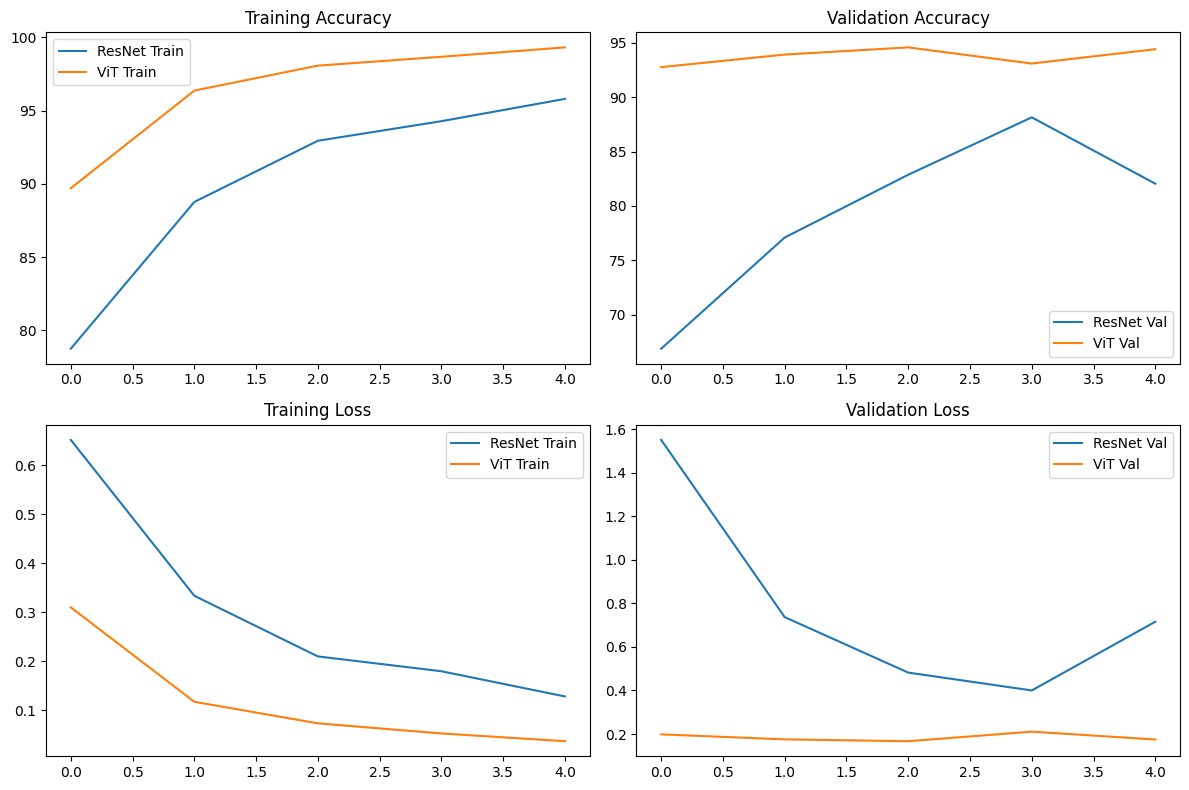


Final Domain Generalization Results:
ResNet-50: Sketch Domain Accuracy: 53.14%
ViT-B/16: Sketch Domain Accuracy: 46.12%


In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(resnet_pacs_train_acc, label='ResNet Train')
plt.plot(vit_pacs_train_acc, label='ViT Train')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(resnet_pacs_val_acc, label='ResNet Val')
plt.plot(vit_pacs_val_acc, label='ViT Val')
plt.title('Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(resnet_pacs_train_loss, label='ResNet Train')
plt.plot(vit_pacs_train_loss, label='ViT Train')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(resnet_pacs_val_loss, label='ResNet Val')
plt.plot(vit_pacs_val_loss, label='ViT Val')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results
print("\nFinal Domain Generalization Results:")
print(f"ResNet-50: Sketch Domain Accuracy: {resnet_sketch_acc:.2f}%")
print(f"ViT-B/16: Sketch Domain Accuracy: {vit_sketch_acc:.2f}%")

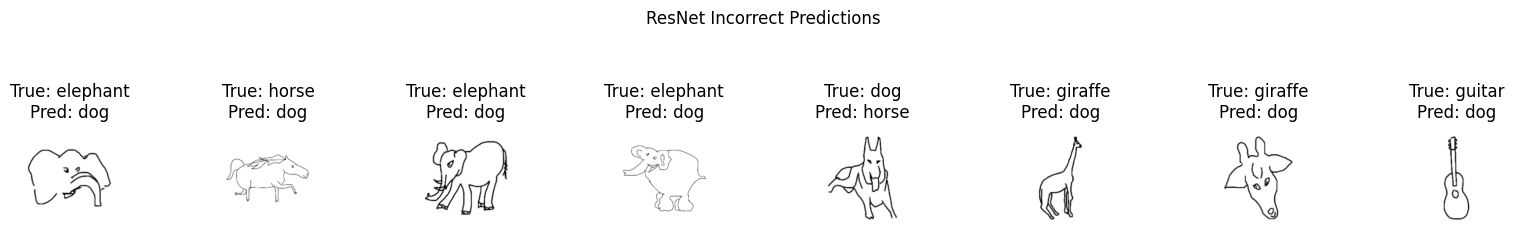

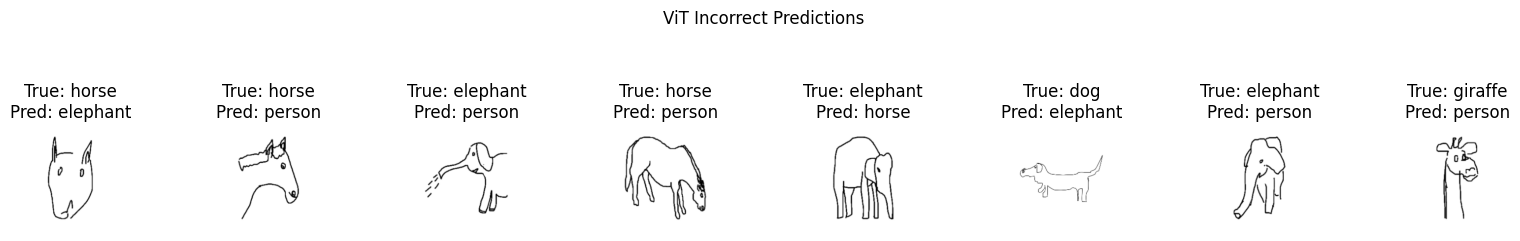

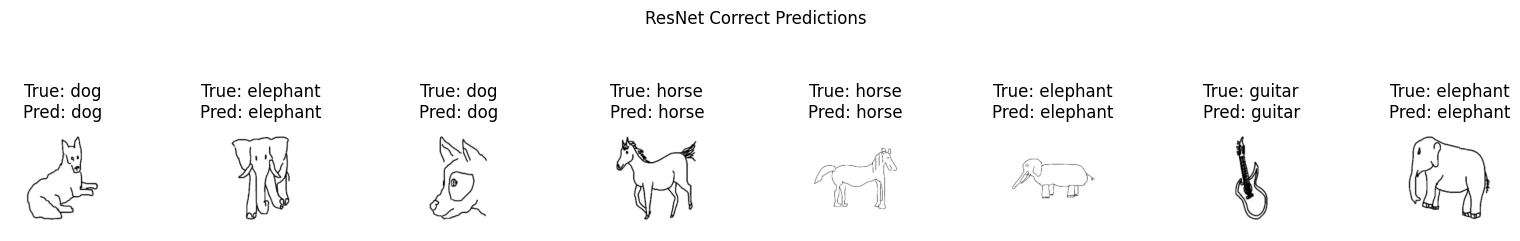

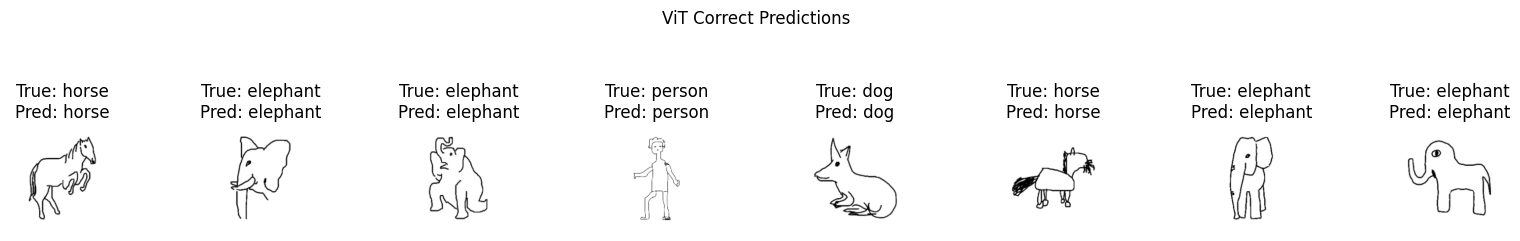

In [24]:
# Visualize correct and incorrect predictions for ResNet and ViT on the test set
import matplotlib.pyplot as plt

def get_predictions(model, dataloader, device):
    model.eval()
    all_images, all_labels, all_preds = [], [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    images = torch.cat(all_images)
    labels = torch.cat(all_labels)
    preds = torch.cat(all_preds)
    return images, labels, preds
import random

def show_examples(images, labels, preds, class_names, correct=True, n=8, title=""):
    mask = (labels == preds) if correct else (labels != preds)
    idxs = torch.where(mask)[0]
    if len(idxs) == 0:
        print("No examples to show.")
        return
    idxs = idxs.tolist()
    random.shuffle(idxs)
    idxs = idxs[:n]
    plt.figure(figsize=(16, 2))
    for i, idx in enumerate(idxs):
        img = images[idx] * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        img = img.permute(1,2,0).numpy().clip(0,1)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {class_names[labels[idx]]}\nPred: {class_names[preds[idx]]}")
    plt.suptitle(title, y=1.18)
    plt.tight_layout()
    plt.show()

# Get class names for PACS
class_names = pacs_train.classes if hasattr(pacs_train, 'classes') else ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

# Get predictions for ResNet
resnet_images, resnet_labels, resnet_preds = get_predictions(resnet_pacs, pacs_test_loader, DEVICE)
# Get predictions for ViT
vit_images, vit_labels, vit_preds = get_predictions(vit_pacs, pacs_test_loader, DEVICE)

# Show incorrect predictions
show_examples(resnet_images, resnet_labels, resnet_preds, class_names, correct=False, n=8, title="ResNet Incorrect Predictions")
show_examples(vit_images, vit_labels, vit_preds, class_names, correct=False, n=8, title="ViT Incorrect Predictions")

# Show correct predictions
show_examples(resnet_images, resnet_labels, resnet_preds, class_names, correct=True, n=8, title="ResNet Correct Predictions")
show_examples(vit_images, vit_labels, vit_preds, class_names, correct=True, n=8, title="ViT Correct Predictions")